In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm

# Importing the modules themselves for reloading
import TradePosition
import TouchArea
import TradingStrategy
import TouchDetection

# Reloading the modules to apply any changes
import importlib
importlib.reload(TradePosition)
importlib.reload(TouchArea)
importlib.reload(TradingStrategy)
importlib.reload(TouchDetection)

from TradePosition import TradePosition
from TouchArea import TouchArea
from TradingStrategy import StrategyParameters, TouchDetectionAreas, TradingStrategy 

from TouchDetection import BacktestTouchDetectionParameters, calculate_touch_detection_area, plot_touch_detection_areas, np_mean, np_median

In [2]:
# symbol = "NVDA"
symbol = "MSFT"
# symbol = "AAPL" #
# symbol = "TJX"
# symbol = "JNJ" #
# symbol = "AMZN"
# symbol = "AZN"
# symbol = "TSLA" #
# symbol = "TJX" #


start_date = "2019-01-01 00:00:00"
end_date =   "2020-01-01 00:00:00"

# start_date = "2024-01-01 00:00:00"
# end_date =   "2024-08-17 00:00:00"

# Usage example:
touch_params = BacktestTouchDetectionParameters(
    symbol=symbol,
    start_date=start_date,
    end_date=end_date,
    atr_period=15,
    level1_period=15,
    multiplier=1.4,
    min_touches=3,
    start_time=None,
    end_time='15:55',
    use_median=True,
    touch_area_width_agg=np_median,
    use_saved_bars=True,
    rolling_avg_decay_rate=0.85
    # export_bars_path=f'bars/bars_{symbol}_{start_date.split()[0]}_{end_date.split()[0]}.csv'
)

# touch_detection_areas = calculate_touch_detection_area(touch_params)

# touch_detection_areas = calculate_touch_detection_area(symbol, start_date, end_date, atr_period=15, level1_period=15, multiplier=1.4, min_touches=3, start_time=None, end_time='15:55', \
#     use_median=True, touch_area_width_agg=np_median, use_saved_bars=True, export_bars_path=f'bars_{symbol}_{start_date.split()[0]}_{end_date.split()[0]}.csv')


In [3]:
# a = touch_detection_areas.bars[touch_detection_areas.mask]['trade_count'].astype(float).describe()
# b = touch_detection_areas.bars[touch_detection_areas.mask]['volume'].astype(float).describe()
# c = touch_detection_areas.bars[touch_detection_areas.mask]['shares_per_trade'].astype(float).describe()
# pd.concat([a,b,c],axis=1)

In [4]:
zoom_start_date = start_date
zoom_end_date = end_date
# zoom_start_date = "2023-05-26 12:00:00"
# zoom_end_date = "2023-05-26 12:40:00"
# plot_touch_detection_areas(touch_detection_areas, zoom_start_date, zoom_end_date)

In [5]:
# len(touch_detection_areas['long_touch_area']) + len(touch_detection_areas['short_touch_area'])

In [6]:
params = StrategyParameters(
    initial_investment=10_000,
    do_longs=True,
    do_shorts=True,
    sim_longs=True,
    sim_shorts=True,
    
    use_margin=True,
    
    times_buying_power=1,
    
    soft_start_time = None, 
    soft_end_time = '15:50',
    
    # slippage_factor=0
)

# strategy = TradingStrategy(touch_detection_areas, params, export_trades_path='trades_output.csv')
# results = strategy.run_backtest()

In [9]:
# symbols = ['AAPL','INTC','JNJ','TSLA','MSFT','AMZN','ABBV']
# symbols = ['AAPL', 'MSFT', 'NVDA', 'TSLA', 'AMZN', 'JPM', 'GOOGL', 'META', 'XOM', 'CVX', 'UNH', 'PFE', 'KO', 'PG', 'BA', 'CAT']
# symbols = ['NVDA', 'JPM', 'GOOGL', 'META', 'XOM', 'CVX', 'UNH', 'PFE', 'KO', 'PG', 'BA', 'CAT']
# symbols = ['AAPL', 'MSFT', 'NVDA', 'GOOGL', 'AMZN', 'TSLA', 'JPM', 'BAC', 'META', 'T', 'VZ', 'XOM', 'CVX', 'JNJ', 'PFE', 'KO'] # generally high-liquidity from 2016 to present
symbols = ['AAPL', 'MSFT', 'NVDA', 'INTC', 'AMZN', 'TSLA', 'DIS', 'JPM', 'BAC', 'GOOGL', 'META', 'XOM', 'CVX', 'JNJ', 'PFE', 'KO'] # test3. generally high-liquidity from 2016 to 2019

In [10]:
trades_folder = 'test3/trades'
graphs_folder = 'test3/graphs'
xbp_folder = 'test3/xbp'

from IPython.utils import io
for s in symbols[10:]:
    touch_params.symbol = s
    touch_params.export_bars_path=f'bars/bars_{touch_params.symbol}_{start_date.split()[0]}_{end_date.split()[0]}.csv'
    
    # print(touch_params.symbol)
    # print(touch_params.export_bars_path)
    results_list = []
    
    # print(touch_params)
    touch_detection_areas = calculate_touch_detection_area(touch_params)
    # continue
    for i in tqdm(list(np.arange(0.5, 4.01, 0.5))):
        
        params.times_buying_power = i
        with io.capture_output() as captured:
            strategy = TradingStrategy(touch_detection_areas, params)
            
            if i == 1:
                strategy.export_trades_path=f'{trades_folder}/trades_{touch_params.symbol}_{start_date.split()[0]}_{end_date.split()[0]}.csv'
                strategy.export_graph_path=f'{graphs_folder}/graph_{touch_params.symbol}_{start_date.split()[0]}_{end_date.split()[0]}.png'
            
            balance, longs_executed, shorts_executed, balance_change, mean_plpc, win_mean_plpc, lose_mean_plpc, winrate, total_costs, \
                avg_sub_pos, avg_transact, count_entry_adjust, count_entry_skip, count_exit_adjust, count_exit_skip, key_stats = \
                strategy.run_backtest()

        trades_executed = longs_executed + shorts_executed
        newrow = {
            'xBP': i,
            'net%': balance_change,
            'balance': balance,
            'cnt': trades_executed,
            # 'AvgPL%': mean_plpc,
            # 'winAvgPL%': win_mean_plpc,
            # 'loseAvgPL%': lose_mean_plpc,
            'WR%': winrate,
            'TotalCosts': total_costs,
            # 'avg sub pos created': avg_sub_pos,
            # 'avg transactions': avg_transact,
            'entryAdjust': count_entry_adjust,
            'entrySkip': count_entry_skip,
            'exitAdjust': count_exit_adjust,
            'exitSkip': count_exit_skip,
            **key_stats
        }
        results_list.append(newrow)

    results = pd.DataFrame(results_list)
    # Format specific columns if needed
    results['xBP'] = results['xBP'].map('{:.1f}'.format)
    results['balance'] = results['balance'].map('${:.4f}'.format)
    results['TotalCosts'] = results['TotalCosts'].map('${:.4f}'.format)

    # Format all float columns
    float_columns = results.select_dtypes(include=['float64']).columns
    results[float_columns] = results[float_columns].applymap('{:.4f}'.format)

    # Display the results
    # pd.set_option('display.max_columns', None)
    filename = f'{xbp_folder}/xbp_{touch_params.symbol}_{start_date.split()[0]}_{end_date.split()[0]}.csv'
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    results.to_csv(filename,index=False)
    # results

Saved bars to bars/bars_META_2019-01-01_2020-01-01.zip
                                    open    high     low   close  volume  \
symbol timestamp                                                           
META   2019-01-02 04:00:00-05:00  127.43  127.43  126.74  126.74  1941.0   
       2019-01-02 04:01:00-05:00  127.43  127.43  126.74  126.74     0.0   
       2019-01-02 04:02:00-05:00  126.86  126.86  126.86  126.86   400.0   
       2019-01-02 04:03:00-05:00  126.86  126.86  126.86  126.86     0.0   
       2019-01-02 04:04:00-05:00  128.73  128.73  128.73  128.73   448.0   

                                  trade_count    vwap  
symbol timestamp                                       
META   2019-01-02 04:00:00-05:00         20.0  127.16  
       2019-01-02 04:01:00-05:00          0.0     NaN  
       2019-01-02 04:02:00-05:00          3.0  126.86  
       2019-01-02 04:03:00-05:00          0.0     NaN  
       2019-01-02 04:04:00-05:00          5.0  128.46  


100%|██████████| 8/8 [14:33<00:00, 109.19s/it]
C:\Users\alexw\AppData\Local\Temp\ipykernel_27276\706542534.py:60: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results[float_columns] = results[float_columns].applymap('{:.4f}'.format)


Saved bars to bars/bars_XOM_2019-01-01_2020-01-01.zip
                                   open   high    low  close  volume  \
symbol timestamp                                                       
XOM    2019-01-02 07:00:00-05:00  51.14  51.14  51.14  51.14   620.0   
       2019-01-02 07:01:00-05:00  51.14  51.14  51.14  51.14     0.0   
       2019-01-02 07:02:00-05:00  50.71  50.71  50.71  50.71   274.0   
       2019-01-02 07:03:00-05:00  50.71  50.71  50.71  50.71     0.0   
       2019-01-02 07:04:00-05:00  50.71  50.71  50.71  50.71     0.0   

                                  trade_count   vwap  
symbol timestamp                                      
XOM    2019-01-02 07:00:00-05:00          9.0  51.10  
       2019-01-02 07:01:00-05:00          0.0    NaN  
       2019-01-02 07:02:00-05:00          3.0  50.71  
       2019-01-02 07:03:00-05:00          0.0    NaN  
       2019-01-02 07:04:00-05:00          0.0    NaN  


100%|██████████| 8/8 [16:26<00:00, 123.29s/it]
C:\Users\alexw\AppData\Local\Temp\ipykernel_27276\706542534.py:60: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results[float_columns] = results[float_columns].applymap('{:.4f}'.format)


Saved bars to bars/bars_CVX_2019-01-01_2020-01-01.zip
                                   open   high    low  close  volume  \
symbol timestamp                                                       
CVX    2019-01-02 07:00:00-05:00  84.87  84.87  84.87  84.87   500.0   
       2019-01-02 07:01:00-05:00  84.87  84.87  84.87  84.87     0.0   
       2019-01-02 07:02:00-05:00  84.87  84.87  84.87  84.87     0.0   
       2019-01-02 07:03:00-05:00  84.87  84.87  84.87  84.87     0.0   
       2019-01-02 07:04:00-05:00  84.87  84.87  84.87  84.87     0.0   

                                  trade_count   vwap  
symbol timestamp                                      
CVX    2019-01-02 07:00:00-05:00          1.0  84.87  
       2019-01-02 07:01:00-05:00          0.0    NaN  
       2019-01-02 07:02:00-05:00          0.0    NaN  
       2019-01-02 07:03:00-05:00          0.0    NaN  
       2019-01-02 07:04:00-05:00          0.0    NaN  


100%|██████████| 8/8 [26:17<00:00, 197.19s/it]
C:\Users\alexw\AppData\Local\Temp\ipykernel_27276\706542534.py:60: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results[float_columns] = results[float_columns].applymap('{:.4f}'.format)


Saved bars to bars/bars_JNJ_2019-01-01_2020-01-01.zip
                                    open    high     low   close  volume  \
symbol timestamp                                                           
JNJ    2019-01-02 06:50:00-05:00  110.17  110.17  110.17  110.17   110.0   
       2019-01-02 06:51:00-05:00  110.17  110.17  110.17  110.17     0.0   
       2019-01-02 06:52:00-05:00  110.17  110.17  110.17  110.17     0.0   
       2019-01-02 06:53:00-05:00  110.17  110.17  110.17  110.17     0.0   
       2019-01-02 06:54:00-05:00  110.17  110.17  110.17  110.17     0.0   

                                  trade_count    vwap  
symbol timestamp                                       
JNJ    2019-01-02 06:50:00-05:00          1.0  110.17  
       2019-01-02 06:51:00-05:00          0.0     NaN  
       2019-01-02 06:52:00-05:00          0.0     NaN  
       2019-01-02 06:53:00-05:00          0.0     NaN  
       2019-01-02 06:54:00-05:00          0.0     NaN  


100%|██████████| 8/8 [23:28<00:00, 176.03s/it]
C:\Users\alexw\AppData\Local\Temp\ipykernel_27276\706542534.py:60: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results[float_columns] = results[float_columns].applymap('{:.4f}'.format)


Saved bars to bars/bars_PFE_2019-01-01_2020-01-01.zip
                                   open   high    low  close  volume  \
symbol timestamp                                                       
PFE    2019-01-02 04:00:00-05:00  34.03  34.03  34.03  34.03   100.0   
       2019-01-02 04:01:00-05:00  34.03  34.03  34.03  34.03     0.0   
       2019-01-02 04:02:00-05:00  34.03  34.03  34.03  34.03     0.0   
       2019-01-02 04:03:00-05:00  34.03  34.03  34.03  34.03     0.0   
       2019-01-02 04:04:00-05:00  34.03  34.03  34.03  34.03     0.0   

                                  trade_count   vwap  
symbol timestamp                                      
PFE    2019-01-02 04:00:00-05:00          1.0  34.03  
       2019-01-02 04:01:00-05:00          0.0    NaN  
       2019-01-02 04:02:00-05:00          0.0    NaN  
       2019-01-02 04:03:00-05:00          0.0    NaN  
       2019-01-02 04:04:00-05:00          0.0    NaN  


100%|██████████| 8/8 [10:54<00:00, 81.86s/it]
C:\Users\alexw\AppData\Local\Temp\ipykernel_27276\706542534.py:60: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results[float_columns] = results[float_columns].applymap('{:.4f}'.format)


Saved bars to bars/bars_KO_2019-01-01_2020-01-01.zip
                                   open   high    low  close  volume  \
symbol timestamp                                                       
KO     2019-01-02 04:00:00-05:00  39.58  39.58  39.58  39.58   100.0   
       2019-01-02 04:01:00-05:00  39.58  39.58  39.58  39.58     0.0   
       2019-01-02 04:02:00-05:00  39.58  39.58  39.58  39.58     0.0   
       2019-01-02 04:03:00-05:00  39.58  39.58  39.58  39.58     0.0   
       2019-01-02 04:04:00-05:00  39.58  39.58  39.58  39.58     0.0   

                                  trade_count   vwap  
symbol timestamp                                      
KO     2019-01-02 04:00:00-05:00          1.0  39.58  
       2019-01-02 04:01:00-05:00          0.0    NaN  
       2019-01-02 04:02:00-05:00          0.0    NaN  
       2019-01-02 04:03:00-05:00          0.0    NaN  
       2019-01-02 04:04:00-05:00          0.0    NaN  


100%|██████████| 8/8 [11:34<00:00, 86.78s/it]
C:\Users\alexw\AppData\Local\Temp\ipykernel_27276\706542534.py:60: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results[float_columns] = results[float_columns].applymap('{:.4f}'.format)


In [11]:
# symbols = ['AAPL', 'MSFT', 'NVDA', 'TSLA', 'AMZN', 'JPM', 'GOOGL', 'META', 'XOM', 'CVX', 'UNH', 'PFE', 'KO', 'PG', 'BA', 'CAT','INTC','JNJ','ABBV'] # test2

In [12]:
results_combined = pd.DataFrame()
for s in symbols:
    fname = f'{xbp_folder}/xbp_{s}_{start_date.split()[0]}_{end_date.split()[0]}.csv'
    results = pd.read_csv(fname)
    results['symbol'] = s
    first_column = results.pop('symbol') 
    results.insert(0, 'symbol', first_column) 
    results_combined = pd.concat([results_combined, results],ignore_index=True)
results_combined['WinMax'] = results_combined[['LwinMax', 'SwinMax']].max(axis=1)
results_combined['LoseMin'] = results_combined[['LloseMin', 'SloseMin']].max(axis=1)
pd.set_option('display.max_rows', results_combined.shape[0])
pd.set_option('display.max_columns', results_combined.shape[1])
results_combined.loc[results_combined.xBP.isin({1,4})].sort_values('net%',ascending=False)

,symbol,xBP,net%,balance,cnt,WR%,TotalCosts,entryAdjust,entrySkip,exitAdjust,exitSkip,AllAvg,WinAvg,LoseAvg,LwinAvg,LwinMax,SwinAvg,SwinMax,LloseAvg,LloseMin,SloseAvg,SloseMin,WinMax,LoseMin
39,AMZN,4.0,5796.1435,$589614.3526,9000,39.9222,$19429.2200,5122,1773,1368,170,0.1791,0.7758,-0.2174,0.8139,39.2204,0.7371,21.1887,-0.2120,-1.8211,-0.2229,-2.0917,39.2204,-1.8211
7,AAPL,4.0,5057.7011,$515770.1081,8580,39.9417,$20065.0636,5705,1904,1269,0,0.2034,0.8601,-0.2333,0.8966,21.4899,0.8175,13.3219,-0.2248,-2.5972,-0.2431,-2.2642,21.4899,-2.2642
47,TSLA,4.0,4410.5169,$451051.6933,6941,39.5188,$15565.8580,4488,1568,1301,780,0.3663,1.5914,-0.4342,1.5701,23.0490,1.6158,42.6940,-0.4202,-2.6330,-0.4491,-3.2531,42.6940,-2.6330
41,TSLA,1.0,3694.5784,$379457.8432,6983,39.5102,$13844.4731,4057,1483,1103,778,0.0959,0.4092,-0.1088,0.3981,5.7594,0.4220,10.6828,-0.1057,-0.6655,-0.1121,-0.8143,10.6828,-0.6655
33,AMZN,1.0,3690.2620,$379026.1982,9134,39.8621,$12335.8773,3111,1140,809,185,0.0504,0.2080,-0.0540,0.2179,12.0207,0.1979,7.0578,-0.0526,-0.4553,-0.0555,-0.5221,12.0207,-0.4553
1,AAPL,1.0,3643.1951,$374319.5136,8689,39.5097,$14253.0369,3805,1370,670,0,0.0548,0.2270,-0.0577,0.2394,5.9965,0.2128,4.4046,-0.0555,-0.6493,-0.0603,-0.5661,5.9965,-0.5661
87,META,4.0,3305.4846,$340548.4575,9071,40.1279,$6711.8063,5143,2134,1163,8,0.2392,0.9797,-0.2571,1.0111,40.2818,0.9461,13.1550,-0.2563,-4.8306,-0.2580,-1.9646,40.2818,-1.9646
23,NVDA,4.0,2749.2770,$284927.6983,8259,38.9999,$41483.0343,5262,1928,1229,131,0.3013,1.3637,-0.3780,1.3884,29.5008,1.3390,90.6456,-0.3786,-3.5286,-0.3773,-4.5890,90.6456,-3.5286
81,META,1.0,2546.7472,$264674.7224,9058,40.4836,$5580.2274,4221,1734,906,8,0.0640,0.2535,-0.0648,0.2618,9.9584,0.2445,4.2219,-0.0645,-1.1978,-0.0652,-0.5964,9.9584,-0.5964
17,NVDA,1.0,2230.0439,$233004.3857,8277,38.9996,$36359.7515,5080,1945,1086,131,0.0783,0.3490,-0.0947,0.3569,7.3744,0.3410,22.6592,-0.0950,-0.8821,-0.0945,-1.1534,22.6592,-0.8821


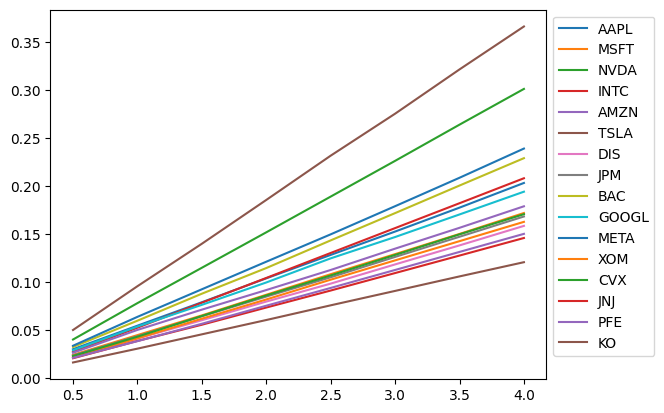

In [13]:
for s in symbols:
    fname = f'{xbp_folder}/xbp_{s}_{start_date.split()[0]}_{end_date.split()[0]}.csv'
    results = pd.read_csv(fname)
    plt.plot(results.xBP.astype(float).to_list(), results.AllAvg.astype(float).to_list(), label=s)
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.show()

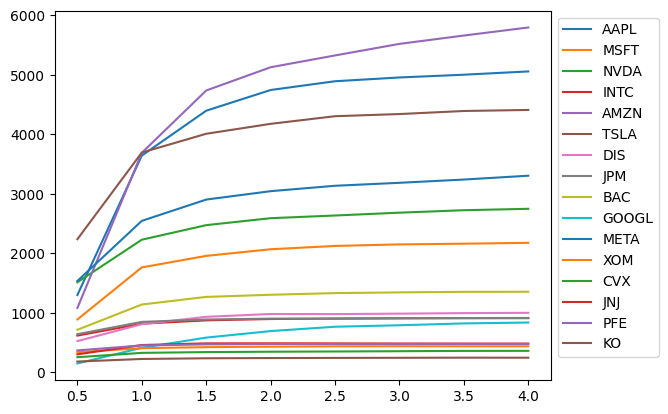

In [14]:
for s in symbols:
    fname = f'{xbp_folder}/xbp_{s}_{start_date.split()[0]}_{end_date.split()[0]}.csv'
    results = pd.read_csv(fname)
    plt.plot(results.xBP.astype(float).to_list(), results['net%'].astype(float).to_list(), label=s)
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.show()

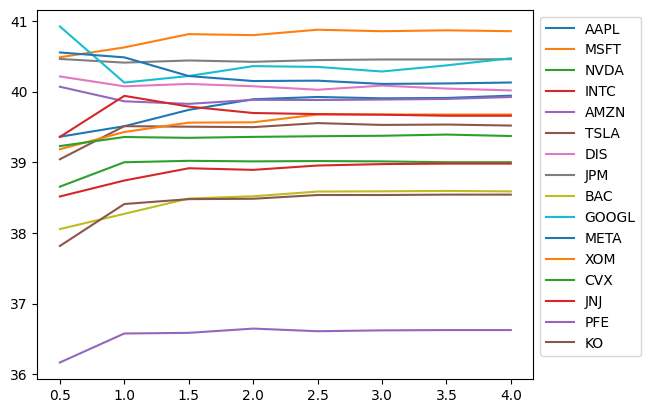

In [15]:
for s in symbols:
    fname = f'{xbp_folder}/xbp_{s}_{start_date.split()[0]}_{end_date.split()[0]}.csv'
    results = pd.read_csv(fname)
    plt.plot(results.xBP.astype(float).to_list(), results['WR%'].astype(float).to_list(), label=s)
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.show()